# 2. Data Cleaning & Analysis

## Problem Statement

I am a community manager for a web-based forum encouraging water sports activity. Recently there have been many posts regarding kayaking/canoeing and surfing activities on my platform. I have been tasked to separate these posts into their respective fields and at the same time learn what are the common talking points of the respective hobby. 

I will be looking at 2 subreddits, (r/kayaking & r/surfing) and learn what separates them and also do so for my own platform.

### Data Cleaning

In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import nltk
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
from PIL import Image

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.ensemble import RandomForestClassifier

#### r/kayaking

In [2]:
#Call previous saved kayaking data
kayak_df = pd.read_csv('./data/reddit_kayaking.csv')

# Check the first few rows.
kayak_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,is_gallery,title,...,created_utc,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,poll_data
0,NaN,Kayaking,NaN,t2_8et28d6z,False,NaN,0,False,True,[Author] My solo kayak trip in -18 a few weeks...,...,1.606339e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Kayaking,NaN,t2_v2jo5,False,NaN,0,False,NaN,Needing to pack a snow brush,...,1.606315e+09,0,NaN,False,image,{'images': [{'source': {'url': 'https://previe...,90773748-b7db-11e3-aba5-12313d056a4d,NaN,NaN,NaN
2,NaN,Kayaking,NaN,t2_ehaja,False,NaN,0,False,NaN,Mid November glacier paddle,...,1.606285e+09,0,NaN,False,image,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN
3,NaN,Kayaking,NaN,t2_8tecgqz2,False,NaN,0,False,True,I have been looking for some time for a way to...,...,1.606365e+09,2,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Kayaking,NaN,t2_7at1jj01,False,NaN,0,False,NaN,Peace on the Isle of Wight 🧡,...,1.606332e+09,0,NaN,False,image,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN


In [3]:
#Check number of observations
kayak_df.shape

(998, 114)

In [4]:
#Dropping duplicate posts by title
kayak_df.drop_duplicates(subset='title', inplace=True)

In [5]:
#Check number of observations to see how many were dropped
len(kayak_df)

991

In [6]:
#Reducing to wanted features
kayak_df = kayak_df[['subreddit','title','selftext']]

In [7]:
#Checking for data type
kayak_df.dtypes

subreddit    object
title        object
selftext     object
dtype: object

In [8]:
#Checking for null values
kayak_df.isnull().sum()

subreddit      0
title          0
selftext     727
dtype: int64

In [9]:
#Defining function for blank posts
def blank(df):
    for i in df:
        print(i)
        print('Blank Rows: {}'.format(str((df[i] == '').sum())))
        print('Percentage of Blank: {}'.format(str(np.round((df[i] == '').sum() / df[i].shape[0] *100, 2)) + "%"))

In [10]:
#Inputting kayak_df to function
blank(kayak_df)

subreddit
Blank Rows: 0
Percentage of Blank: 0.0%
title
Blank Rows: 0
Percentage of Blank: 0.0%
selftext
Blank Rows: 0
Percentage of Blank: 0.0%


Since the null values is significant (over % of the total number of observations) I have chosen to focus on the classifying the posts with `title` instead.

In [11]:
#Dropping unwanted feature
kayak_df.drop(columns='selftext',inplace=True)

In [12]:
#Checking for head
kayak_df.head()

,subreddit,title
0,Kayaking,[Author] My solo kayak trip in -18 a few weeks...
1,Kayaking,Needing to pack a snow brush
2,Kayaking,Mid November glacier paddle
3,Kayaking,I have been looking for some time for a way to...
4,Kayaking,Peace on the Isle of Wight 🧡


In [13]:
#Using CountVectorizer to tokenize words and removing stopwords
cvec = CountVectorizer(stop_words='english')

In [14]:
#Fitting dataframe into CountVectorizer
cvec.fit(kayak_df['title'])

CountVectorizer(stop_words='english')

In [15]:
#Turning tokenized words into a dataframe
kayak_title = pd.DataFrame(cvec.transform(kayak_df['title']).todense(),
                       columns=cvec.get_feature_names())

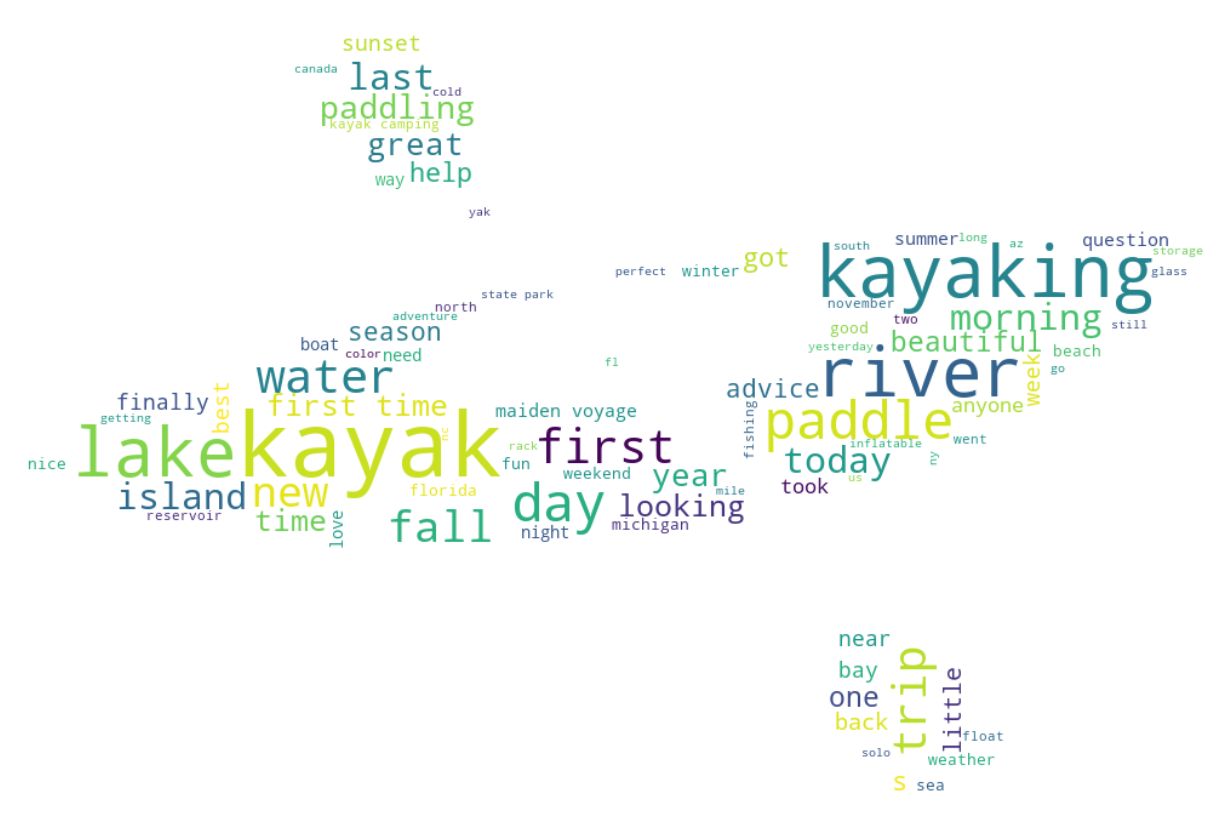

In [16]:
#Visualising data into wordcloud
kayak_mask = np.array(Image.open("./images/kayak.png"))
kayak_words = ''
for val in kayak_df['title']: 
      
    #typecaste each val to string 
    val = str(val) 
  
    #split the value 
    tokens = val.split() 
      
    #Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    kayak_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10,mask=kayak_mask).generate(kayak_words) 

#plot the WordCloud image   
plt.figure(figsize=[30,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('./images/kayakwordcloud.png');

In [17]:
#Converting top 50 features into a dataframe
kayak_top50 = pd.DataFrame(kayak_title.sum().sort_values(ascending=False).head(50), columns=['count'])

C:\Users\asyraf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


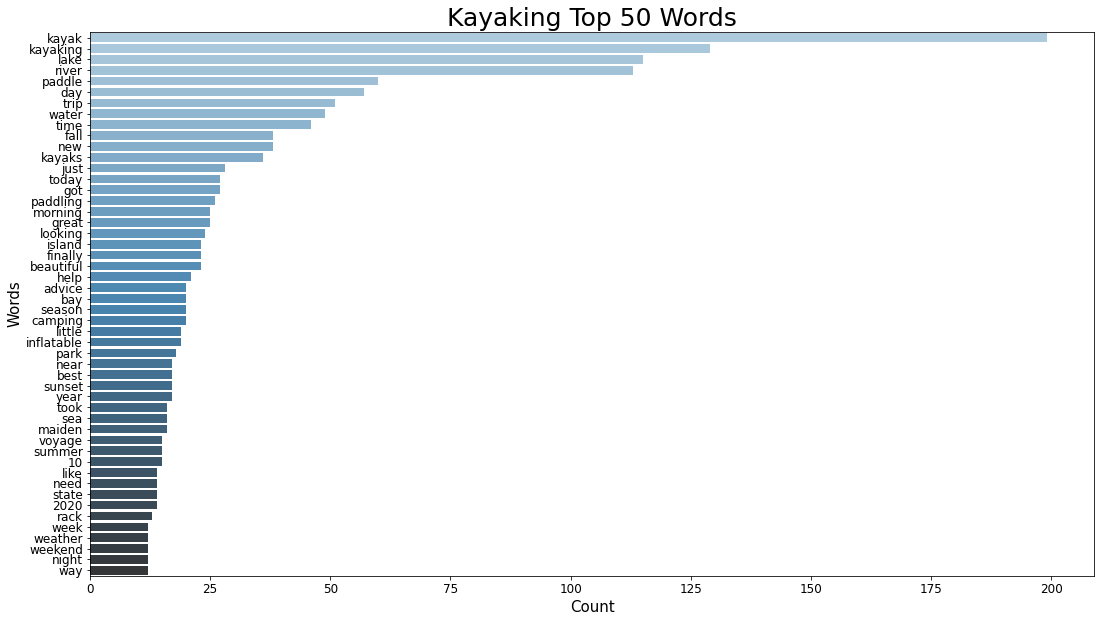

In [18]:
plt.figure(figsize=(18,10))
sns.barplot('count',kayak_top50.index, data=kayak_top50, palette='Blues_d',orient='h')
plt.title('Kayaking Top 50 Words', fontsize=25)
plt.ylabel('Words', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.tick_params(labelsize=12)
plt.savefig('./images/kayaktop50.png');

As expected, the words from the subreddit name are amongst the most recurring used word in the subreddit. Words such as `kayak`,`kayaking` and `kayaks` will be dropped when fitting into our model.

#### r/surfing

In [19]:
#Call previous saved surfing data
surf_df = pd.read_csv('./data/reddit_surfing.csv')

# Check the first few rows.
surf_df.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,url_overridden_by_dest,preview,link_flair_template_id,crosspost_parent_list,crosspost_parent,is_gallery,media_metadata,gallery_data,poll_data,author_cakeday
0,NaN,surfing,"Bitch and moan and complain away, kooks!",t2_42s11,False,NaN,0,False,The Wednesday Whine,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,surfing,NaN,t2_87ku8tvw,False,NaN,0,False,Chip barrel!,[],...,https://i.redd.it/n75ofgno5h161.jpg,{'images': [{'source': {'url': 'https://previe...,4012be6c-8e7a-11e6-aef0-0e41ffa1e583,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,surfing,NaN,t2_45t5yssd,False,NaN,0,False,The crowd watching the historic Nazaré few wee...,[],...,https://i.redd.it/y7p8jn1rfe161.jpg,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,surfing,NaN,t2_31b7ksg,False,NaN,0,False,SF sessions being had,[],...,https://i.redd.it/zgq7f2owug161.jpg,{'images': [{'source': {'url': 'https://previe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,surfing,TLDR; Don’t leave your car key unsecured hidde...,t2_69n9hzni,False,NaN,0,False,Surfers being robbed - Malibu,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#Check number of observations
surf_df.shape

(996, 115)

In [21]:
#Dropping duplicate posts by title
surf_df.drop_duplicates(subset='title', inplace=True)

In [22]:
#Checking number of observations after dropping
len(surf_df)

941

In [23]:
#Reducing to wanted features
surf_df = surf_df[['subreddit','title','selftext']]

In [24]:
#Checking for data type
surf_df.dtypes

subreddit    object
title        object
selftext     object
dtype: object

In [25]:
#Checking for null values
surf_df.isnull().sum()

subreddit      0
title          0
selftext     524
dtype: int64

In [26]:
#Checking for blank posts
blank(surf_df)

subreddit
Blank Rows: 0
Percentage of Blank: 0.0%
title
Blank Rows: 0
Percentage of Blank: 0.0%
selftext
Blank Rows: 0
Percentage of Blank: 0.0%


In [27]:
#Dropping unwanted column
surf_df.drop(columns='selftext',inplace=True)

In [28]:
#Checking for columns for final dataset
surf_df.head()

,subreddit,title
0,surfing,The Wednesday Whine
1,surfing,Chip barrel!
2,surfing,The crowd watching the historic Nazaré few wee...
3,surfing,SF sessions being had
4,surfing,Surfers being robbed - Malibu


In [29]:
#Fitting dataframe into CountVectorizer
cvec.fit(surf_df['title'])

CountVectorizer(stop_words='english')

In [30]:
#Turning tokenized words into a dataframe
surf_title = pd.DataFrame(cvec.transform(surf_df['title']).todense(),
                       columns=cvec.get_feature_names())

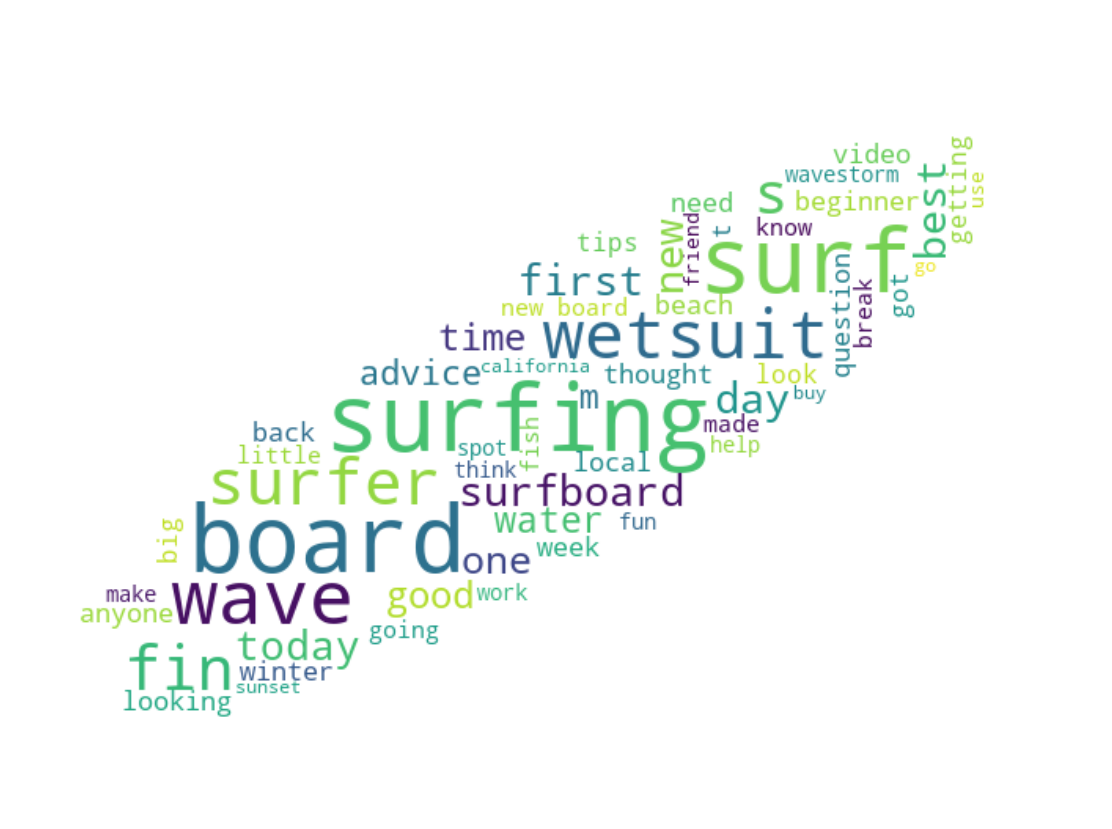

In [31]:
surf_mask = np.array(Image.open("./images/surfboard.png"))
surf_words = ''
for val in surf_df['title']: 
      
    #typecaste each val to string 
    val = str(val) 
  
    #split the value 
    tokens = val.split() 
      
    #Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    surf_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10,mask=surf_mask).generate(surf_words) 

#plot the WordCloud image   
plt.figure(figsize=[30,15])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('./images/surfwordcloud.png');

As expected, the words from the subreddit name are amongst the most recurring used word in the subreddit. Words such as `surf`,`surfing`,`surfers`,`surfboard` and `surfer` will be dropped when fitting into our model.

In [32]:
#Checking and converting top 50 surf features into a dataframe
surf_top50 = pd.DataFrame(surf_title.sum().sort_values(ascending=False).head(50), columns=['count'])

C:\Users\asyraf\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


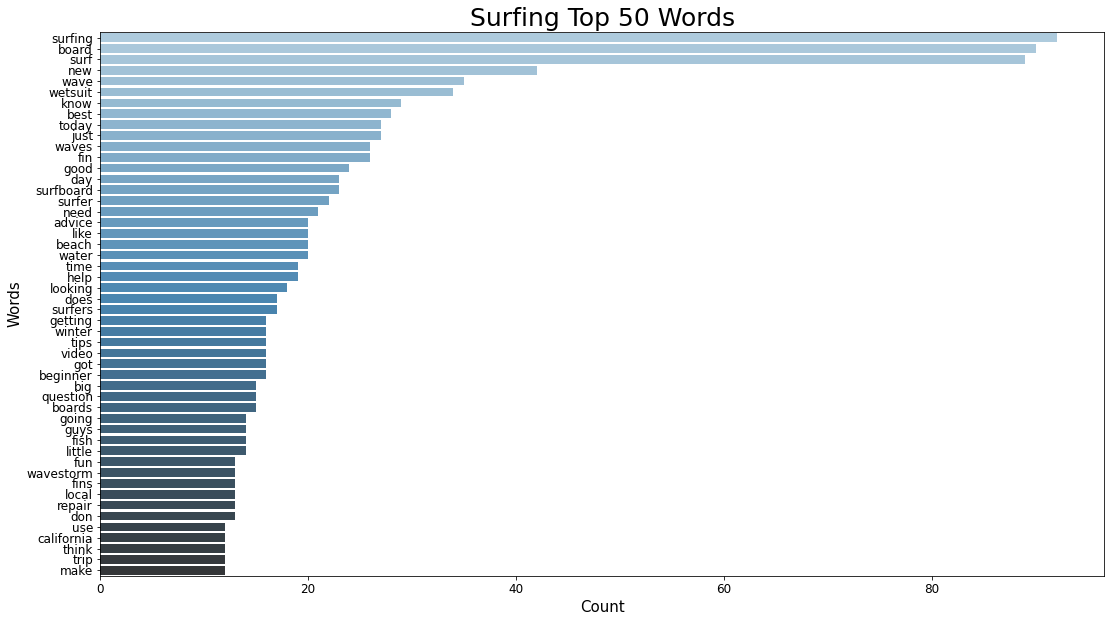

In [33]:
plt.figure(figsize=(18,10))
sns.barplot('count',surf_top50.index, data=surf_top50, palette='Blues_d',orient='h')
plt.title('Surfing Top 50 Words', fontsize=25)
plt.ylabel('Words', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.tick_params(labelsize=12)
plt.savefig('./images/surftop50.png');

From the top 50 features of the two datasets, we can see that there are overlapping words that may affect our model later. We will look at the overlapping words once more in the next section before we add them to our stopwords.

In [34]:
set(surf_title.columns).intersection(set(kayak_title.columns))

{'10',
 '100',
 '11',
 '12',
 '120',
 '140',
 '15',
 '17',
 '1st',
 '20',
 '2018',
 '2020',
 '24',
 '31',
 '50',
 '70',
 'able',
 'actually',
 'add',
 'advantage',
 'advice',
 'ago',
 'ahead',
 'ahh',
 'air',
 'amazing',
 'america',
 'amp',
 'anniversary',
 'anybody',
 'apartment',
 'app',
 'apple',
 'appreciated',
 'arch',
 'area',
 'ask',
 'attack',
 'attempt',
 'australia',
 'awesome',
 'backpack',
 'backside',
 'bad',
 'bag',
 'bars',
 'based',
 'bay',
 'bc',
 'beach',
 'beautiful',
 'beauty',
 'beginner',
 'best',
 'better',
 'big',
 'bike',
 'birthday',
 'bit',
 'black',
 'blue',
 'body',
 'bonus',
 'bought',
 'boy',
 'brace',
 'brand',
 'brazil',
 'break',
 'broken',
 'buddies',
 'buddy',
 'budget',
 'build',
 'building',
 'built',
 'buy',
 'buying',
 'ca',
 'california',
 'called',
 'cam',
 'came',
 'canada',
 'cape',
 'car',
 'carbon',
 'carolina',
 'catch',
 'caught',
 'central',
 'chance',
 'changing',
 'channel',
 'cheap',
 'check',
 'choice',
 'christmas',
 'city',
 'class

In [35]:
#converting into a list
overlap_list = list(set(surf_title.columns).intersection(set(kayak_title.columns)))

In [36]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(overlap_list)

#### Preprocessing

In [37]:
#Checking for 10 kayak observations
kayak_df.head(10)

,subreddit,title
0,Kayaking,[Author] My solo kayak trip in -18 a few weeks...
1,Kayaking,Needing to pack a snow brush
2,Kayaking,Mid November glacier paddle
3,Kayaking,I have been looking for some time for a way to...
4,Kayaking,Peace on the Isle of Wight 🧡
5,Kayaking,Looking to get an entry level kayak. Please help!
6,Kayaking,Among the grass and cypress in Florida
7,Kayaking,P&amp;H Valkyrie
8,Kayaking,"Plains, Trains &amp; Kayaks! Wabash River Kaya..."
9,Kayaking,13ft kayak on short bed truck


In [38]:
#Remove words with 'kayak'
kayak_df['title'] = [re.sub('[Kk]ayak\w*','',i) for i in kayak_df['title']]

In [39]:
#Remove digits
kayak_df['title'] = [re.sub("\d+", "", i) for i in kayak_df['title']]

In [40]:
#Remove words with 2 or fewer letters
kayak_df['title'] = [re.sub(r'\b\w{1,2}\b','',i) for i in kayak_df['title']]

In [41]:
#Checking if words have been removed
kayak_df.head()

,subreddit,title
0,Kayaking,[Author] solo trip - few weeks ago. Manage...
1,Kayaking,Needing pack snow brush
2,Kayaking,Mid November glacier paddle
3,Kayaking,have been looking for some time for way mak...
4,Kayaking,Peace the Isle Wight 🧡


In [42]:
#Checking for 10 surf observations
surf_df.tail(10)

,subreddit,title
935,surfing,I've made a track about the feelings that surf...
936,surfing,youtube series about French surfers sailing ar...
937,surfing,Significant rain the South Bay 10/25. Consider...
938,surfing,"I apologize for the poor photo quality, but th..."
939,surfing,Need help on how to remove yellow shade from b...
940,surfing,Florida Surfing
941,surfing,Guys.. shit happened. This is my first time ha...
942,surfing,"Whomever you are, I hope you have a good weekend"
943,surfing,"Wipeout Montage Hueneme, Ca 10/25"
944,surfing,Best board for surfing noob?


In [43]:
#Remove words with 'surf'
surf_df['title'] = [re.sub('[Ss]urf\w*','',i) for i in surf_df['title']]

In [44]:
#Remove digits
surf_df['title'] = [re.sub("\d+", "", i) for i in surf_df['title']]

In [45]:
#Remove words with 2 or fewer letters
surf_df['title'] = [re.sub(r'\b\w{1,2}\b','',i) for i in surf_df['title']]

In [46]:
#Checking if words have been removed
surf_df.tail()

,subreddit,title
940,surfing,Florida
941,surfing,Guys.. shit happened. This first time having...
942,surfing,"Whomever you are, hope you have good weekend"
943,surfing,"Wipeout Montage Hueneme, /"
944,surfing,Best board for noob?


In [47]:
#Merging the two datasets
merge_df = pd.concat([kayak_df, surf_df], ignore_index=True)

In [48]:
#Mapping the subreddit values to a binary classification
merge_df['subreddit'] = merge_df['subreddit'].map({'surfing': 0, 'Kayaking': 1})

In [49]:
#Checking for mapping error
merge_df['subreddit'].unique()

array([1, 0], dtype=int64)

## Modelling

### Baseline

In [50]:
merge_df['subreddit'].value_counts(normalize=True)

1    0.51294
0    0.48706
Name: subreddit, dtype: float64

The baseline accuracy for r/kayaking is 0.51294 whereas r/surfing is 0.48706

In [51]:
X = merge_df['title']
y = merge_df['subreddit']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

cvec then see shape in a pd.

In [53]:
#Using CountVectorizer to tokenize words and removing stopwords
cvec = CountVectorizer(stop_words=my_stop_words)

In [54]:
#Fitting dataframe into CountVectorizer
cvec.fit(X_train)

CountVectorizer(stop_words=frozenset({'10', '100', '11', '12', '120', '140',
                                      '15', '17', '1st', '20', '2018', '2020',
                                      '24', '31', '50', '70', 'a', 'able',
                                      'about', 'above', 'across', 'actually',
                                      'add', 'advantage', 'advice', 'after',
                                      'afterwards', 'again', 'against', 'ago', ...}))

In [55]:
#Turning tokenized words into a dataframe
train_title = pd.DataFrame(cvec.transform(X_train).todense(),
                       columns=cvec.get_feature_names())

In [56]:
#Checking for train features
train_title.head()

,abandoned,absolute,acadia,accepted,access,accessible,accessories,accord,account,acquired,...,youtube,yukon,yulex,zealand,zee,zero,zhanay,zipless,zoffinger,zwick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
#Checking for train shape
train_title.shape

(1449, 2271)

### CountVectorizer and LogisticRegression

In [58]:
#input models for our pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [59]:
#parameters for our pipeline
pipe_params = {
    'cvec__stop_words': [my_stop_words],
    'cvec__max_features': range(100,2900,100)
}

In [60]:
#creating grid search for our parameters
gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5)

In [61]:
#fitting train data into model
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_features': range(100, 2900, 100),
                         'cvec__stop_words': [frozenset({'10', '100', '11',
                                                         '12', '120', '140',
                                                         '15', '17', '1st',
                                                         '20', '2018', '2020',
                                                         '24', '31', '50', '70',
                                                         'a', 'able', 'about',
                                                         'above', 'across',
                                                         'actually', 'add',
                                                         'advantage', 'advice',
                                                         'after', 'after

In [62]:
#checking for best parameters
gs.best_params_

{'cvec__max_features': 1800,
 'cvec__stop_words': frozenset({'clean',
            'into',
            'moon',
            'real',
            'waves',
            'degree',
            'below',
            'person',
            'saturday',
            '100',
            'stream',
            'seemed',
            'women',
            'though',
            'morning',
            'question',
            'spots',
            'becoming',
            'waters',
            '20',
            'themselves',
            'built',
            'make',
            'north',
            'favourite',
            'another',
            'darkness',
            'close',
            'doesn',
            'friend',
            'needed',
            'longer',
            'minutes',
            '120',
            'rate',
            'las',
            'advantage',
            'today',
            'gets',
            'pictures',
            'rock',
            'story',
            'must',
            'winter',


In [63]:
#predicting y for our test data
y_predgs = gs.best_estimator_.predict(X_test)

In [64]:
print('Train Score: {}'.format(gs.best_score_))
print('Test Score: {}'.format(gs.best_estimator_.score(X_test,y_test)))

Train Score: 0.8032883904068726
Test Score: 0.7619047619047619


From our accuracy score, we can already tell that our model is overfitting as we can only predict posts at a **76.19%** accuracy for test data whereas **80.33%** accuracy for our train data.

In [65]:
#Checking model scores for test data
print(classification_report(y_test, y_predgs))

              precision    recall  f1-score   support

           0       1.00      0.51      0.68       235
           1       0.68      1.00      0.81       248

    accuracy                           0.76       483
   macro avg       0.84      0.76      0.74       483
weighted avg       0.84      0.76      0.75       483



In [66]:
#creating confusion matrix for model
pd.DataFrame(confusion_matrix(y_test, y_predgs), index=['Actual r/Surfing', 'Actual r/Kayaking'], columns=['Predicted r/Surfing', 'Predicted r/Kayaking'])

,Predicted r/Surfing,Predicted r/Kayaking
Actual r/Surfing,120,115
Actual r/Kayaking,0,248


The confusion matrix suggests that our model is high has a **high Type 1 Error(False Positive)** and very **low Type 2 Error (False Negative)**. This means that we are better at predicting Surfing posts as compared to Kayaking posts. Let's look at how the feature coefficients and how it predicts the post classification.

In [67]:
#create dataframe of features with their corresponding coefficient values
coef_df = pd.DataFrame({'feature':gs.best_estimator_.named_steps['cvec'].get_feature_names(),'coef':gs.best_estimator_.named_steps['lr'].coef_[0].tolist()})
coef_df.sort_values(by=['coef'], inplace=True, ascending=False)

In [68]:
#checking if values are sorted properly
coef_df.head()

,feature,coef
687,island,1.438057
679,inflatable,1.413101
279,camping,1.294733
1149,reservoir,1.215991
1396,state,1.090613


In [69]:
#initialising CountVectorizer
cvec = CountVectorizer(stop_words=my_stop_words)

In [70]:
#fitting kayak dataframe
cvec.fit(kayak_df['title'])

CountVectorizer(stop_words=frozenset({'10', '100', '11', '12', '120', '140',
                                      '15', '17', '1st', '20', '2018', '2020',
                                      '24', '31', '50', '70', 'a', 'able',
                                      'about', 'above', 'across', 'actually',
                                      'add', 'advantage', 'advice', 'after',
                                      'afterwards', 'again', 'against', 'ago', ...}))

In [71]:
#converting vectorized words into a dataframe
kayak_clean_title = pd.DataFrame(cvec.transform(kayak_df['title']).todense(), 
                       columns=cvec.get_feature_names())

In [72]:
#looking for words in our model that matches kayak features
coef_df[coef_df['feature'].isin(kayak_clean_title.columns)].head(10)

,feature,coef
687,island,1.438057
679,inflatable,1.413101
279,camping,1.294733
1149,reservoir,1.215991
1396,state,1.090613
634,float,1.057442
1495,tandem,1.048315
1061,purchase,1.038906
100,autumn,1.033144
196,boat,1.012912


The top 10 words predicting kayak posts are in the table above. Words like `island` and `inflatable` correctly describes the kayaking hobby as it is a vessel that is used for personal exploration of islands and at the same time there are widely available inflatable kayaks in the market.

In [73]:
#finding the words that negates the prediction of kayak posts that are not in kayak clean title
coef_df[~coef_df['feature'].isin(kayak_clean_title.columns)].tail(10)

,feature,coef
504,diego,-1.229497
761,longboard,-1.246102
1736,wetsuits,-1.275274
630,fins,-1.356101
195,boards,-1.403785
1718,wavestorm,-1.427226
629,fin,-1.764426
1716,wave,-2.177002
1735,wetsuit,-2.333839
191,board,-2.774995


The words with negative coefficient suggests that these are the features that negates the correct prediction of a kayaking post. In other words, they are predicting a surf post. Appropriately, words such as `board`,`fin`, `longboard` and `wetsuits` correctly describes the surfing hobby as these are gears for the hobby itself. `wave` is also correctly there as surfing is essentially the act of riding the waves. The presence of `board` and `boards` suggest that it might be better for us to use lemmatization for future models.

### TfidfVectorizer and LogisticRegression

In [74]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [75]:
pipe_params = {
    'tfidf__stop_words': [my_stop_words],
    'tfidf__max_features': range(100,2900,100)
}

In [76]:
gs2 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5)

In [77]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tfidf__max_features': range(100, 2900, 100),
                         'tfidf__stop_words': [frozenset({'10', '100', '11',
                                                          '12', '120', '140',
                                                          '15', '17', '1st',
                                                          '20', '2018', '2020',
                                                          '24', '31', '50',
                                                          '70', 'a', 'able',
                                                          'about', 'above',
                                                          'across', 'actually',
                                                          'add', 'advantage',
                                                          'advice', 'af

In [78]:
gs2.best_params_

{'tfidf__max_features': 1900,
 'tfidf__stop_words': frozenset({'clean',
            'into',
            'moon',
            'real',
            'waves',
            'degree',
            'below',
            'person',
            'saturday',
            '100',
            'stream',
            'seemed',
            'women',
            'though',
            'morning',
            'question',
            'spots',
            'becoming',
            'waters',
            '20',
            'themselves',
            'built',
            'make',
            'north',
            'favourite',
            'another',
            'darkness',
            'close',
            'doesn',
            'friend',
            'needed',
            'longer',
            'minutes',
            '120',
            'rate',
            'las',
            'advantage',
            'today',
            'gets',
            'pictures',
            'rock',
            'story',
            'must',
            'winter'

In [79]:
y_predgs2 = gs2.best_estimator_.predict(X_test)

In [80]:
print('Train Score: {}'.format(gs2.best_score_))
print('Test Score: {}'.format(gs2.best_estimator_.score(X_test,y_test)))

Train Score: 0.8143348049158812
Test Score: 0.7743271221532091


In [81]:
print(classification_report(y_test, y_predgs2))

              precision    recall  f1-score   support

           0       1.00      0.54      0.70       235
           1       0.69      1.00      0.82       248

    accuracy                           0.77       483
   macro avg       0.85      0.77      0.76       483
weighted avg       0.84      0.77      0.76       483



From our accuracy score, we can already tell that our model is overfitting as we can only predict posts at a **77.43%** accuracy for test data whereas **81.43%** accuracy for our train data. It also performs slightly better than our CountVectorizer model.

In [82]:
pd.DataFrame(confusion_matrix(y_test, y_predgs2), index=['Actual r/Surfing', 'Actual r/Kayaking'], columns=['Predicted r/Surfing', 'Predicted r/Kayaking'])

,Predicted r/Surfing,Predicted r/Kayaking
Actual r/Surfing,126,109
Actual r/Kayaking,0,248


The confusion matrix suggests that our model is high has a **high Type 1 Error(False Positive)** and very **low Type 2 Error (False Negative)**. This means that we are better at predicting Surfing posts as compared to Kayaking posts. Let's look at how the feature coefficients and how it predicts the post classification.

In [83]:
#create dataframe of features with their corresponding coefficient values
coef_df2 = pd.DataFrame({'feature':gs2.best_estimator_.named_steps['tfidf'].get_feature_names(),'coef':gs2.best_estimator_.named_steps['lr'].coef_[0].tolist()})
coef_df2.sort_values(by=['coef'], inplace=True, ascending=False)

In [84]:
#checking if values are sorted properly
coef_df2.head()

,feature,coef
701,island,1.552619
679,inflatable,1.511864
279,camping,1.405560
1249,reservoir,1.255306
1496,state,1.150922


In [85]:
#initialising CountVectorizer
tfidf = TfidfVectorizer(stop_words=my_stop_words)

In [86]:
#fitting kayak dataframe
tfidf.fit(kayak_df['title'])

TfidfVectorizer(stop_words=frozenset({'10', '100', '11', '12', '120', '140',
                                      '15', '17', '1st', '20', '2018', '2020',
                                      '24', '31', '50', '70', 'a', 'able',
                                      'about', 'above', 'across', 'actually',
                                      'add', 'advantage', 'advice', 'after',
                                      'afterwards', 'again', 'against', 'ago', ...}))

In [87]:
#converting vectorized words into a dataframe
kayak_clean_title2 = pd.DataFrame(cvec.transform(kayak_df['title']).todense(), 
                       columns=cvec.get_feature_names())

In [88]:
#looking for words in our model that matches kayak features
coef_df2[coef_df2['feature'].isin(kayak_clean_title.columns)].head(10)

,feature,coef
701,island,1.552619
679,inflatable,1.511864
279,camping,1.405560
1249,reservoir,1.255306
1496,state,1.150922
634,float,1.105997
860,maiden,1.066482
100,autumn,1.061503
1595,tandem,1.060946
196,boat,1.058350


When using the TfidfVectorizer, we can see that the top 10 words are similar to the CountVectorizer, only the coefficient are different. This is due to the fact that the tvec model puts a weightage on the frequency of a word used within a document rather than counting the number of time it appears, like the cvec model. This explains why the model performs better at classifying our test data, albeit by a small percentage.

In [89]:
#finding the words that negates the prediction of kayak posts that are not in kayak clean title
coef_df2[~coef_df2['feature'].isin(kayak_clean_title.columns)].tail(10)

,feature,coef
569,edit,-1.191904
852,longboard,-1.221270
504,diego,-1.251788
630,fins,-1.437005
1818,wavestorm,-1.438034
195,boards,-1.511393
629,fin,-1.966379
1816,wave,-2.352946
1835,wetsuit,-2.492182
191,board,-3.525097


Again, we see that the top 10 words for the tvec model are similar to our cvec model. Only with a different coefficient.

### CountVectorizer and MultinomialNB

In [90]:
#Crafting pipeline and model for Grid Search
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [91]:
#Defining parameters for the grid search
pipe_params = {
    'cvec__stop_words': [my_stop_words],
    'cvec__max_features': range(100,2900,100)
}

In [92]:
#Initialise grid search over cross validation of 5
gs3 = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv=5)

In [93]:
#Fitting the train data into the grid search
gs3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_features': range(100, 2900, 100),
                         'cvec__stop_words': [frozenset({'10', '100', '11',
                                                         '12', '120', '140',
                                                         '15', '17', '1st',
                                                         '20', '2018', '2020',
                                                         '24', '31', '50', '70',
                                                         'a', 'able', 'about',
                                                         'above', 'across',
                                                         'actually', 'add',
                                                         'advantage', 'advice',
                                                         'after', 'afterward

In [94]:
#Checking the best performing parameter
gs3.best_params_

{'cvec__max_features': 1900,
 'cvec__stop_words': frozenset({'clean',
            'into',
            'moon',
            'real',
            'waves',
            'degree',
            'below',
            'person',
            'saturday',
            '100',
            'stream',
            'seemed',
            'women',
            'though',
            'morning',
            'question',
            'spots',
            'becoming',
            'waters',
            '20',
            'themselves',
            'built',
            'make',
            'north',
            'favourite',
            'another',
            'darkness',
            'close',
            'doesn',
            'friend',
            'needed',
            'longer',
            'minutes',
            '120',
            'rate',
            'las',
            'advantage',
            'today',
            'gets',
            'pictures',
            'rock',
            'story',
            'must',
            'winter',


In [95]:
#Predict classification for the test data
y_predgs3 = gs3.best_estimator_.predict(X_test)

In [96]:
#Checking Train and Test Scores
print('Train Score: {}'.format(gs3.best_score_))
print('Test Score: {}'.format(gs3.best_estimator_.score(X_test,y_test)))

Train Score: 0.8226178260350793
Test Score: 0.7991718426501035


From our accuracy score, we can already tell that our model is slightly overfitting as we can only predict posts at a **79.91%** accuracy for test data whereas **82.26%** accuracy for our train data. It also performs slightly better than our logistic models.

In [97]:
#Printing out scores table of model
print(classification_report(y_test, y_predgs3))

              precision    recall  f1-score   support

           0       1.00      0.59      0.74       235
           1       0.72      1.00      0.84       248

    accuracy                           0.80       483
   macro avg       0.86      0.79      0.79       483
weighted avg       0.86      0.80      0.79       483



In [98]:
#Visualising Confusion Matrix for predictions
pd.DataFrame(confusion_matrix(y_test, y_predgs3), index=['Actual r/Surfing', 'Actual r/Kayaking'], columns=['Predicted r/Surfing', 'Predicted r/Kayaking'])

,Predicted r/Surfing,Predicted r/Kayaking
Actual r/Surfing,138,97
Actual r/Kayaking,0,248


The confusion matrix suggests that our model is high has a **high Type 1 Error(False Positive)** and very **low Type 2 Error (False Negative)**. This means that we are better at predicting Surfing posts as compared to Kayaking posts.

Judging from the performance of our Multinomial Model, let's try with the TfidfVectorizer to see if the trend of improving our model from CountVectorizer continues.

### TfidfVectorizer and MultinomialNB

In [99]:
#Crafting pipeline and model for Grid Search
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [100]:
#setting pipeline parameters
pipe_params = {
    'tfidf__stop_words': [my_stop_words],
    'tfidf__max_features': range(100,2900,100)
}

In [101]:
#Initialise grid search over cross validation of 5
gs4 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5)

In [102]:
#fitting our model with train data
gs4.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tfidf__max_features': range(100, 2900, 100),
                         'tfidf__stop_words': [frozenset({'10', '100', '11',
                                                          '12', '120', '140',
                                                          '15', '17', '1st',
                                                          '20', '2018', '2020',
                                                          '24', '31', '50',
                                                          '70', 'a', 'able',
                                                          'about', 'above',
                                                          'across', 'actually',
                                                          'add', 'advantage',
                                                          'advice', 'after'

In [103]:
#checking the best parameters
gs4.best_params_

{'tfidf__max_features': 1900,
 'tfidf__stop_words': frozenset({'clean',
            'into',
            'moon',
            'real',
            'waves',
            'degree',
            'below',
            'person',
            'saturday',
            '100',
            'stream',
            'seemed',
            'women',
            'though',
            'morning',
            'question',
            'spots',
            'becoming',
            'waters',
            '20',
            'themselves',
            'built',
            'make',
            'north',
            'favourite',
            'another',
            'darkness',
            'close',
            'doesn',
            'friend',
            'needed',
            'longer',
            'minutes',
            '120',
            'rate',
            'las',
            'advantage',
            'today',
            'gets',
            'pictures',
            'rock',
            'story',
            'must',
            'winter'

In [104]:
#predicting our y values on test data
y_predgs4 = gs4.best_estimator_.predict(X_test)

In [105]:
print('Train Score: {}'.format(gs4.best_score_))
print('Test Score: {}'.format(gs4.best_estimator_.score(X_test,y_test)))

Train Score: 0.8226178260350793
Test Score: 0.7991718426501035


From our accuracy score, we can already tell that our model is slightly overfitting as we can only predict posts at a **79.92%** accuracy for test data whereas **82.26%** accuracy for our train data.

In [106]:
print(classification_report(y_test, y_predgs4))

              precision    recall  f1-score   support

           0       1.00      0.59      0.74       235
           1       0.72      1.00      0.84       248

    accuracy                           0.80       483
   macro avg       0.86      0.79      0.79       483
weighted avg       0.86      0.80      0.79       483



In [107]:
#creating confusion matrix
pd.DataFrame(confusion_matrix(y_test, y_predgs4), index=['Actual r/Surfing', 'Actual r/Kayaking'], columns=['Predicted r/Surfing', 'Predicted r/Kayaking'])

,Predicted r/Surfing,Predicted r/Kayaking
Actual r/Surfing,138,97
Actual r/Kayaking,0,248


The confusion matrix suggests that our model is high has a **high Type 1 Error(False Positive)** and very **low Type 2 Error (False Negative)**. This means that we are better at predicting Surfing posts as compared to Kayaking posts.

The Multinomial Model with TfidfVectorizer improved from the cvec model by the slightest of margins. The difference is negligible as the predicted values in the confusion matrix are the same. Let's try the Random Forest model next to see if there is an improvement in our accuracy.

### CountVectorizer and RandomForest

In [108]:
#Crafting pipeline and model for Grid Search
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

In [109]:
#defining parameters
pipe_params = {
    'cvec__stop_words': [my_stop_words],
    'cvec__max_features': range(100,2900,100),
    'rf__n_estimators': [100, 150, 200],
}

In [110]:
#initialising our grid search
gs5 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5)

In [111]:
#fitting train data
gs5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'cvec__max_features': range(100, 2900, 100),
                         'cvec__stop_words': [frozenset({'10', '100', '11',
                                                         '12', '120', '140',
                                                         '15', '17', '1st',
                                                         '20', '2018', '2020',
                                                         '24', '31', '50', '70',
                                                         'a', 'able', 'about',
                                                         'above', 'across',
                                                         'actually', 'add',
                                                         'advantage', 'advice',
                                                         'after', 'a

In [112]:
#checking best parameters
gs5.best_params_

{'cvec__max_features': 2200,
 'cvec__stop_words': frozenset({'clean',
            'into',
            'moon',
            'real',
            'waves',
            'degree',
            'below',
            'person',
            'saturday',
            '100',
            'stream',
            'seemed',
            'women',
            'though',
            'morning',
            'question',
            'spots',
            'becoming',
            'waters',
            '20',
            'themselves',
            'built',
            'make',
            'north',
            'favourite',
            'another',
            'darkness',
            'close',
            'doesn',
            'friend',
            'needed',
            'longer',
            'minutes',
            '120',
            'rate',
            'las',
            'advantage',
            'today',
            'gets',
            'pictures',
            'rock',
            'story',
            'must',
            'winter',


In [113]:
#predicting y value on test data
y_predgs5 = gs5.best_estimator_.predict(X_test)

In [114]:
print('Train Score: {}'.format(gs5.best_score_))
print('Test Score: {}'.format(gs5.best_estimator_.score(X_test,y_test)))

Train Score: 0.7894857415582865
Test Score: 0.7536231884057971


From our accuracy score, we can already tell that our model is slightly overfitting as we can only predict posts at a **75.57%** accuracy for test data whereas **78.94%** accuracy for our train data.

In [115]:
print(classification_report(y_test, y_predgs5))

              precision    recall  f1-score   support

           0       1.00      0.49      0.66       235
           1       0.68      1.00      0.81       248

    accuracy                           0.75       483
   macro avg       0.84      0.75      0.73       483
weighted avg       0.83      0.75      0.74       483



In [116]:
pd.DataFrame(confusion_matrix(y_test, y_predgs5), index=['Actual r/Surfing', 'Actual r/Kayaking'], columns=['Predicted r/Surfing', 'Predicted r/Kayaking'])

,Predicted r/Surfing,Predicted r/Kayaking
Actual r/Surfing,116,119
Actual r/Kayaking,0,248


The confusion matrix suggests that our model is high has a **high Type 1 Error(False Positive)** and very **low Type 2 Error (False Negative)**. This means that we are better at predicting Surfing posts as compared to Kayaking posts.

The Random Forest and CountVectorizer model has improved our data in terms of overfitting. However, our accuracy on test data has been affected as it's the lowest amongst the previous 4 models so far.

### TfidfVectorizer and RandomForest

In [117]:
#Crafting pipeline and model for Grid Search
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

In [118]:
#defining parameters
pipe_params = {
    'tfidf__stop_words': [my_stop_words],
    'tfidf__max_features': range(100,2900,100),
    'rf__n_estimators': [100, 150, 200],
}

In [119]:
#initialising grid search
gs6 = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv=5)

In [120]:
#fitting train model
gs6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__n_estimators': [100, 150, 200],
                         'tfidf__max_features': range(100, 2900, 100),
                         'tfidf__stop_words': [frozenset({'10', '100', '11',
                                                          '12', '120', '140',
                                                          '15', '17', '1st',
                                                          '20', '2018', '2020',
                                                          '24', '31', '50',
                                                          '70', 'a', 'able',
                                                          'about', 'above',
                                                          'across', 'actually',
                                                          'add', 'advantage',
     

In [121]:
#checking for best parameters
gs6.best_params_

{'rf__n_estimators': 150,
 'tfidf__max_features': 2700,
 'tfidf__stop_words': frozenset({'clean',
            'into',
            'moon',
            'real',
            'waves',
            'degree',
            'below',
            'person',
            'saturday',
            '100',
            'stream',
            'seemed',
            'women',
            'though',
            'morning',
            'question',
            'spots',
            'becoming',
            'waters',
            '20',
            'themselves',
            'built',
            'make',
            'north',
            'favourite',
            'another',
            'darkness',
            'close',
            'doesn',
            'friend',
            'needed',
            'longer',
            'minutes',
            '120',
            'rate',
            'las',
            'advantage',
            'today',
            'gets',
            'pictures',
            'rock',
            'story',
            'm

In [122]:
#predicting y value on test data
y_predgs6 = gs6.best_estimator_.predict(X_test)

In [123]:
print('Train Score: {}'.format(gs6.best_score_))
print('Test Score: {}'.format(gs6.best_estimator_.score(X_test,y_test)))

Train Score: 0.7908674382531917
Test Score: 0.7556935817805382


From our accuracy score, we can already tell that our model is slightly overfitting as we can only predict posts at a **74.95%** accuracy for test data whereas **79.02%** accuracy for our train data.

In [124]:
print(classification_report(y_test, y_predgs6))

              precision    recall  f1-score   support

           0       1.00      0.50      0.66       235
           1       0.68      1.00      0.81       248

    accuracy                           0.76       483
   macro avg       0.84      0.75      0.74       483
weighted avg       0.83      0.76      0.74       483



In [125]:
pd.DataFrame(confusion_matrix(y_test, y_predgs6), index=['Actual r/Surfing', 'Actual r/Kayaking'], columns=['Predicted r/Surfing', 'Predicted r/Kayaking'])

,Predicted r/Surfing,Predicted r/Kayaking
Actual r/Surfing,117,118
Actual r/Kayaking,0,248


The confusion matrix suggests that our model is high has a **high Type 1 Error(False Positive)** and very **low Type 2 Error (False Negative)**. This means that we are better at predicting Surfing posts as compared to Kayaking posts.

The TfidfVectorizer and RandomForest has performed worse as compared to the the cvec RandomForest. It is more overfitting and the accuracy has dropped slightly.

## Best Model Misclassification Analysis

In [126]:
#Converting test data to dataframe
misclass = pd.DataFrame(X_test)

#Assigning actual y values
misclass['actual'] = y_test

#Assigning predicted y values
misclass['predicted'] = y_predgs4

In [127]:
misclass.head()

,title,actual,predicted
649,Best activity for teaching collaboration,1,1
723,"Paddle (jantex, schwarzer, epic etc.)",1,1
690,Setting out the mobile bay after big storm,1,1
1759,Ireland going off ' nut yesterday 🙌,0,1
1908,Tips improve takeoff and stance?,0,0


In [128]:
#filtering for only misclassified posts
misclass_wrong = misclass[misclass['actual'] != misclass['predicted']]
misclass_wrong.head()

,title,actual,predicted
1759,Ireland going off ' nut yesterday 🙌,0,1
1788,Good waves and bad technique from Morocco,0,1
1380,Ribs,0,1
1483,Beginner spots the bay area,0,1
1482,People who film themselves what you use and ...,0,1


In [129]:
#filtering for Type 1 Errors
false_pos = misclass_wrong[misclass_wrong['predicted'] == 1]
false_pos.shape

(97, 3)

In [130]:
pd.options.display.max_rows = 97
false_pos

,title,actual,predicted
1759,Ireland going off ' nut yesterday 🙌,0,1
1788,Good waves and bad technique from Morocco,0,1
1380,Ribs,0,1
1483,Beginner spots the bay area,0,1
1482,People who film themselves what you use and ...,0,1
1129,Fun waves today 🤙,0,1
1630,STOP,0,1
1182,"Pelican tries drop , gets worked",0,1
1062,This one felt good,0,1
1103,"Felt great, looked good for once.",0,1


We can generally classify most of these posts into a few broad categories:

- Posts that are generic with no reference to either hobbies
- Posts that are purely emojis or special characters
- Posts that consist of short sentences (<5 words)
- Posts that state a geographical location

There are also some instances that they are not classified properly due to the absence of lemmatization in the words. Words such as `waves` are not classified properly as the model was not able to recognise the similarity to the word `wave` that was a strong performing feature for Surfing Post Classification.

In [131]:
#Filtering for Type 2 Errors
false_neg = misclass_wrong[misclass_wrong['predicted'] == 0]
false_neg.shape

(0, 3)

As expected, there are no Type 2 Errors for this model.

## Conclusion

### Findings

- **MultinomialNB + TfidfVectorizer Model** performs the best amongst the other models in terms of reducing overfitting and accuracy.
- The best model is able to predict at a **79.92% accuracy**.
- **Prevalent Type 1 Error** (Wrongly Predicting Kayaking Post) throughout all 4 models. Suggesting that there might be an existence of a bias due to the baseline score. In other words, when the model is unable to classify a post, it goes back to the baseline score as kayaking has a higher percentage of 51.3%.
- Generally TfidfVectorizer tends to improve the model by increasing score or reducing overfitting (although by a small margin)

### Limitations

- Many of the errors, were due to posts having root words that have been identified with strong coefficients. The machine was unable to distinguish the words.
- At 79.92% accuracy, the model may not be able to effectively predict (with low error) as the number of posts increases.
- Machine is also unable to classify or predict usage of special characters or emojis that may be of a prevalent use in the future.

### Recommendations & Further Exploration for Stakeholder

- The accuracy suggests that you would require additional manpower to filter misclassified posts for your forum if the total number of posts is large.
- Train machine to be able to identify variations of a root word via lemmatization.
- Continually expand the database of stopwords with emojis, special characters and geographical locations or landmarks to be able to correctly classify future posts.